In [75]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import statsmodels.stats.proportion as smp
import matplotlib.pyplot as plt
%matplotlib inline

Загрузим данные и посмотрим на них

In [76]:
df = pd.read_csv('credit_card_default_analysis.csv')

In [77]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID           30000 non-null int64
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null int64
dtypes: int64(25)
memory usage: 5.7 MB


Мы видим, что у нас есть 25 признаков для 30 000 заёмщиков, и пропусков в значениях признакав нет. Все наши признаки целочисленного типа.

## 1. Исследование размера кредитного лимита (LIMIT_BAL)

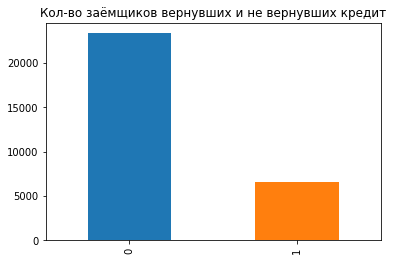

In [79]:
df['default'].value_counts().plot(kind='bar');
plt.title('Кол-во заёмщиков вернувших и не вернувших кредит');

In [80]:
df['default'].value_counts()

0    23364
1     6636
Name: default, dtype: int64

Мы видим, что кол-во заемщиков вернувших кредит почти в 4 раза больше, чем не вернувших. То есть выборка не сбалансированная.

Построим гистограммы распределения размера кредитного лимита: 
 1. среди тех, кто вернул кредит
 2. среди тех, кто не вернул

In [81]:
limit_bal_returned = df[df['default']==0]['LIMIT_BAL'].values
limit_bal_not_returned = df[df['default']==1]['LIMIT_BAL'].values

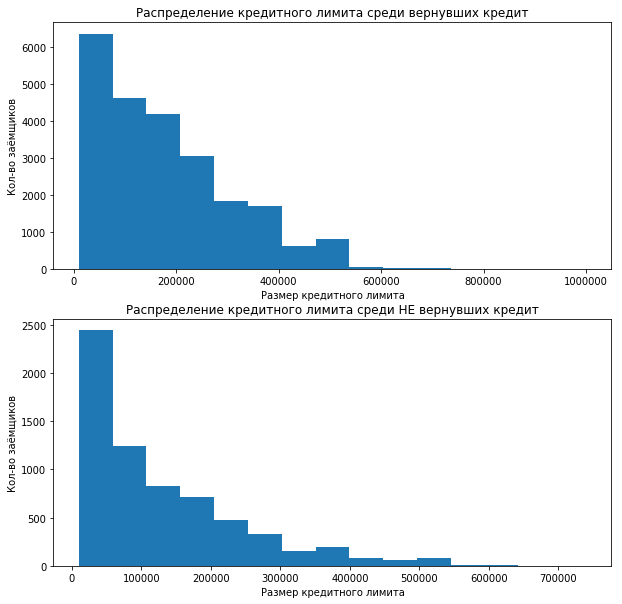

In [82]:
plt.figure(figsize=(10,10))

plt.subplot(211)
plt.hist(limit_bal_returned, bins=15);
plt.xlabel('Размер кредитного лимита')
plt.ylabel('Кол-во заёмщиков')
plt.title('Распределение кредитного лимита среди вернувших кредит');

plt.subplot(212)
plt.hist(limit_bal_not_returned, bins=15);
plt.xlabel('Размер кредитного лимита')
plt.ylabel('Кол-во заёмщиков')
plt.title('Распределение кредитного лимита среди НЕ вернувших кредит');

Мы видим, что распределения сильно скошены и далеки от нормального распределения. 

Так же на графиках видно, что значения размера кредитного лимита для не вернувших кредит меньше, чем для вернувших. 

Так как мы не можем сделать предположения, из какого распределения получена наша выборка, то воспользуемся Bootstrap методом для получения интервальной оценки медиан каждой подвыборки: вернувших и не вернувших кредит. Bootstrap является универсальным методом для подсчёта статистик и не имеет специфичных требований к распределению данных и самим данным.

In [83]:
def create_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(len(data), size=(n_samples, len(data)))
    
    return data[indices]

def get_stat_interval(stat, alpha=0.05):
    return np.percentile(stat, [100*alpha/2, 100*(1-alpha/2)])

In [84]:
# Получим интервальную оценку медианы 
# для размера кредитного лимита вернувших кредит. 
np.random.seed(0)

bootstrap_samples = create_bootstrap_samples(limit_bal_returned)
bootstrap_medians_0 = np.median(bootstrap_samples, axis=1)

med_stat_int_for_returned = get_stat_interval(bootstrap_medians_0, alpha=0.05)
print("95% доверительный интервал для медианы размера кредитного лимита заёмщиков, вернувших кредит: ({}, {})"
       .format(*med_stat_int_for_returned))

95% доверительный интервал для медианы размера кредитного лимита заёмщиков, вернувших кредит: (150000.0, 150000.0)


In [85]:
# Получим интервальную оценку медианы 
# для размера кредитного лимита НЕ вернувших кредит. 
np.random.seed(0)

bootstrap_samples = create_bootstrap_samples(limit_bal_not_returned)
bootstrap_medians_1 = np.median(bootstrap_samples, axis=1)

med_stat_int_for_not_returned = get_stat_interval(bootstrap_medians_1, alpha=0.05)
print("95% доверительный интервал для медианы размера кредитного лимита заёмщиков, не вернувших кредит: ({}, {})"
       .format(*med_stat_int_for_not_returned))

95% доверительный интервал для медианы размера кредитного лимита заёмщиков, не вернувших кредит: (80000.0, 90000.0)


Мы видим, что 95% доверительный интервалы, построенные с помощью Bootstrap, не пересекаются. А именно 95% доверительный интервал для размера кредитного лимита вернувших кредит лежит полностью правее, чем для НЕ вернувших. Это говорит о том, что медианы распределений отличаются, и гипотеза о равенстве медиан отвергается на уровне значимости 0.05.

Построим доверительный интервал для разности медиан:

In [86]:
med_diff_int = get_stat_interval(bootstrap_medians_0 - bootstrap_medians_1, alpha=0.05)
print("95% доверительный интервал для разности медиан кредитного лимита заёмщиков, вернувших и не вернувших кредит: ({}, {})"
       .format(*med_diff_int))

95% доверительный интервал для разности медиан кредитного лимита заёмщиков, вернувших и не вернувших кредит: (60000.0, 70000.0)


Мы видим, что 95% доверительный интервал для разности медиан не содержит 0 и лежит строго правее нуля, то есть мы можем отвергнуть нулевую гипотезу о равенстве медиан на уровне значимости 0.05 в пользу двусторонней альтернативы о неравенстве медиан или односторонней альтернативы, что медиана первой подвыборки (вернувших кредит) больше медианы второй подвыборки (не вернувших кредит)

Так как наши подвыборки для размера кредитного лимита независимые, а именно получены на разных объектах (заёмщиках - вернувших и не вернувших кредит), то воспользуемся критерием Манна-Уитни о равенстве распределений для независимых выборок. 

Непараметрический ранговый критерий Манна-Уитни для независимых выборок:

1. Нулевая гипотеза: Распределения совпадают $F_{1}(x)$ = $F_{2}(x)$
2. Двусторонняя альтернатива: Распределения не совпадают $F_{1}(x)$ = $F_{2}(x+\Delta), $ где $ \Delta != 0$
3. Условия применимости: независимость выборок

In [87]:
ss.mannwhitneyu(limit_bal_returned, limit_bal_not_returned, 
                alternative='two-sided')

MannwhitneyuResult(statistic=95786286.5, pvalue=1.2255485818223303e-189)

Мы видим, что достигаемый уровень значимости критерия Манна-Уитни много меньше 0.05, то есть гипотеза о равенстве распределений уверенно отвеграется на уровне значимости 0.05. 

In [116]:
# функция для подсчёта численно оценке практической значимости
def calc_fold_change(C, T):
    if T>=C:
        return T/C
    elif T<C:
        return -C/T
    else:
        return 1

print('Численная оценка практической значимости = {}'
      .format(calc_fold_change(np.median(limit_bal_returned), np.median(limit_bal_not_returned))))

Численная оценка практической значимости = -1.6666666666666667


Из численной оценки мы видим, что средний кредитный лимит вернувших кредит в 1.67 раз больше, чем у тех, кто не вернул кредит. Это значимое отличие. Но с логической точки зрения результаты не сильно значимы, так как из здравого смысла мы понимаем, что кредитный лимит для заёмщиков, не вернувших кредит, будет меньше, чем для заёмщиков, вернувших кредит. Но тем неменее строгая проверка гипотезы о равенстве распределений и её отвержение достаточно важны для подтверждения имперических знаний и наблюдений.

## 2. Исследование пола заёмщиков

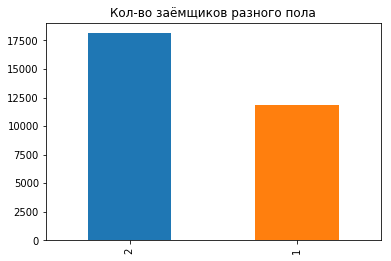

In [88]:
df['SEX'].value_counts().plot(kind='bar');
plt.title('Кол-во заёмщиков разного пола');

In [89]:
df['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

Мы видим, что кол-во заемщиков женского пола почти в 1.5 раза больше мужского. То есть выборка не сбалансированна по признаку пола.

Построим графики распределения пола в двух группах:

1. среди тех, кто вернул кредит
2. среди тех, кто не вернул

In [90]:
sex_returned = df[df['default']==0]['SEX']
sex_not_returned = df[df['default']==1]['SEX']

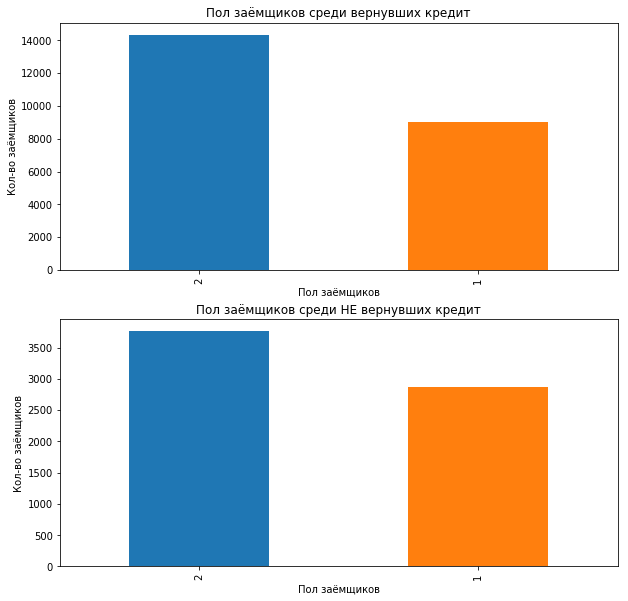

In [91]:
plt.figure(figsize=(10,10))

plt.subplot(211)
sex_returned.value_counts().plot(kind='bar');
plt.xlabel('Пол заёмщиков')
plt.ylabel('Кол-во заёмщиков')
plt.title('Пол заёмщиков среди вернувших кредит');

plt.subplot(212)
sex_not_returned.value_counts().plot(kind='bar');
plt.xlabel('Пол заёмщиков')
plt.ylabel('Кол-во заёмщиков')
plt.title('Пол заёмщиков среди НЕ вернувших кредит');

Из графиков мы видим, что соотношение мужчин и женщин достаточно сильно отличаются в подгруппах, то есть доля мужчин в группе не вернувших кредит больше, чем в группе вернувших кредит. Исследуем это подробнее.

Доли мужчин и женщин в численном выражении в обеих подгруппах.

In [92]:
sex_returned.value_counts() / len(sex_returned)

2    0.61415
1    0.38585
Name: SEX, dtype: float64

In [93]:
sex_not_returned.value_counts() / len(sex_not_returned)

2    0.567058
1    0.432942
Name: SEX, dtype: float64

#### 1. Построим 95% доверительный интервал для доли мужчин в обеих группах. Воспользуемся доверительным интервалом Уилсона для доли.

In [94]:
smp.proportion_confint(sum(sex_returned==1), len(sex_returned), method='wilson')

(0.3796273158089251, 0.392110265969876)

In [95]:
smp.proportion_confint(sum(sex_not_returned==1), len(sex_not_returned), method='wilson')

(0.421062418034934, 0.4448982369717182)

Мы видим, что 95% доверительный интевал доли мужчин в подвыборке вернувших кредит лежит полностью левее 95% доверительного интевала доли мужчин в подвыборке не вернувших кредит. Это говорит о том, что гипотеза о равенстве долей отвергается на уровне значимости 0.05. 

Построим доверительный интервал для разности долей мужчин в группах вернувших и не вернувших кредит (воспользуемся формулами для разности двух долей для независимых выборок):

In [120]:
# Перекодируем значения 2 в 0 для подсчета статистик ниже
sex_returned_replaced_values = np.array(sex_returned)
sex_returned_replaced_values[sex_returned_replaced_values==2]=0

sex_not_returned_replaced_values = np.array(sex_not_returned)
sex_not_returned_replaced_values[sex_not_returned_replaced_values==2]=0

In [121]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = ss.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - ss.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return ss.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - ss.norm.cdf(z_stat)

print("95% доверительный интервал для разности долей мужчин, вернувших и не вернувших кредит: ({}, {})"
      .format(*proportions_diff_confint_ind(sex_returned_replaced_values, sex_not_returned_replaced_values)))

95% доверительный интервал для разности долей мужчин, вернувших и не вернувших кредит: (-0.060548077974896725, -0.03363493274962867)


Мы видим, что 95% доверительный интервал для разности долей мужчин в двух подвыборках вернувших и не вернувших кредит не содержит 0 и лежит строго левее нуля, то есть мы можем отвергнуть нулевую гипотезу о равенстве долей на уровне значимости 0.05 в пользу двусторонней альтернативы о неравенстве долей или односторонней альтернативы, что доля мужчин в первой подвыборке (вернувших кредит) меньше доли мужчин во второй подвыборке (не вернувших кредит). Посчитаем точные значения достигаемых уровней значимости для описанных гипотез:

In [127]:
pvalue_two_sided = proportions_diff_z_test(proportions_diff_z_stat_ind(sex_returned_replaced_values, 
                                                                       sex_not_returned_replaced_values), 
                                           alternative='two-sided')
print('Достигаемый уровень значимости для двусторонней альтернативы:', pvalue_two_sided)

Достигаемый уровень значимости для двусторонней альтернативы:  4.472866521609831e-12


In [129]:
pvalue_less = proportions_diff_z_test(proportions_diff_z_stat_ind(sex_returned_replaced_values, 
                                                                  sex_not_returned_replaced_values), 
                                      alternative='less')
print('Достигаемый уровень значимости для односторонней альтернативы:', pvalue_two_sided)

Достигаемый уровень значимости для односторонней альтернативы:  4.472866521609831e-12


#### 2. Воспользуемся z-критерием для двух долей, что проверить гипотезу о равенстве долей мужчин в обеих группах.

Z-критерий для двух долей для двух независимых выборок:

1. Нулевая гипотеза: Доли совпадают  $p_{1} = p_{2}$ 
2. Двусторонняя альтернатива: Доли не совпадают  $p_{1} != p_{2}$
3. Условие применимости: данные взяты из распределений Бернулли

In [46]:
stat, pvalue = smp.proportions_ztest([sum(sex_returned==1), sum(sex_not_returned==1)], 
                      [len(sex_returned), len(sex_not_returned)])
pvalue

4.472804335814113e-12

Мы видим, что гипотеза о равенстве долей мужчин в обеих группах уверенно отвергается против двусторонней альтернативы на уровне значимости 0.05. 

In [48]:
# Теперь проверим ту же самую гипотезу, но уже против односторонней альтернативы,
# что доля мужчин в подвыборке вернувших кредит МЕНЬШЕ, чем в подвыборке не вернувших кредит

stat, pvalue = smp.proportions_ztest([sum(sex_returned==1), sum(sex_not_returned==1)], 
                      [len(sex_returned), len(sex_not_returned)], 
                  alternative='smaller')
pvalue

2.2364021679070564e-12

Мы видим, что гипотеза о равенстве долей мужчин в обеих группах уверенно отвергается против односторонней альтернативы, что доля мужчин в первый подвыборке МЕНЬШЕ, чем во второй на уровне значимости 0.05.

In [49]:
# Теперь проверим ту же самую гипотезу, но уже против односторонней альтернативы,
# что доля мужчин в подвыборке вернувших кредит БОЛЬШЕ, чем в подвыборке не вернувших кредит

stat, pvalue = smp.proportions_ztest([sum(sex_returned==1), sum(sex_not_returned==1)], 
                      [len(sex_returned), len(sex_not_returned)], 
                  alternative='larger')
pvalue

0.9999999999977636

Мы видим, что гипотеза против односторонней альтернативы о том, что доля мужчин в подвыборке вернувших кредит БОЛЬШЕ, чем в подвыборке не вернувших не отвергается, и это правильно так как мы на предыдущем шаге показали, что доля на самом деле меньше, а не больше. 

## 3. Исследование образования заёмщиков

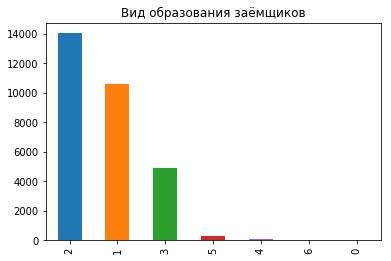

In [24]:
df['EDUCATION'].value_counts().plot(kind='bar');
plt.title('Вид образования заёмщиков');

Мы видим, что подавляющее большинство заёмщиков имеют три вида образования:
1. Бакалавр (самый распространенный тип образования в нашей выборке)
2. Магистр (второй распространенный тип образвания в выборке)
3. Выпускник школы (третий распространенный тип образования)

Построим графики распределения образования в двух группах:

1. среди тех, кто вернул кредит
2. среди тех, кто не вернул

In [25]:
education_returned = df[df['default']==0]['EDUCATION']
education_not_returned = df[df['default']==1]['EDUCATION']

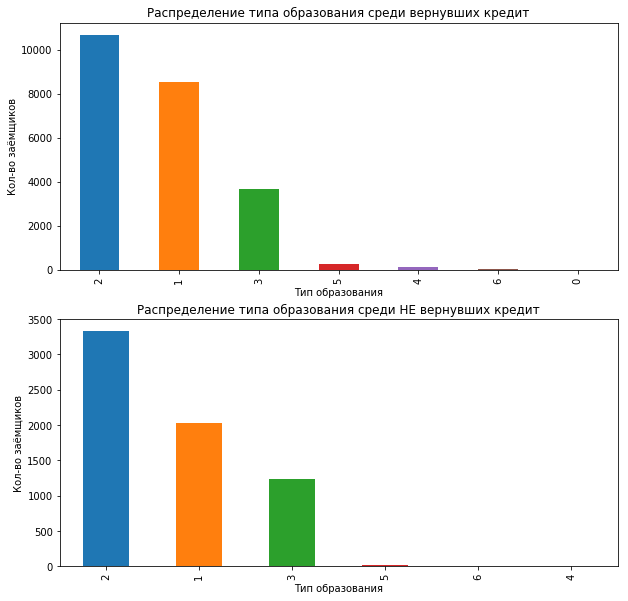

In [26]:
plt.figure(figsize=(10,10))

plt.subplot(211)
education_returned.value_counts().plot(kind='bar');
plt.xlabel('Тип образования')
plt.ylabel('Кол-во заёмщиков')
plt.title('Распределение типа образования среди вернувших кредит');

plt.subplot(212)
education_not_returned.value_counts().plot(kind='bar');
plt.xlabel('Тип образования')
plt.ylabel('Кол-во заёмщиков')
plt.title('Распределение типа образования среди НЕ вернувших кредит');

Из графиков мы видим, что распределение видов образования в подргуппах очень схожи, нет существенных бросающихся в глаза отличий долей заёмщиков с каким-нибудь конкретным видом образования. Исследуем подробнее и внимательнее данные в численном выражении.

Доли видов образования в численном выражении в обеих подгруппах: вернувших и не вернувших кредит

In [27]:
education_returned.value_counts() / len(education_returned)

2    0.457970
1    0.365905
3    0.157507
5    0.011214
4    0.004965
6    0.001840
0    0.000599
Name: EDUCATION, dtype: float64

In [28]:
education_not_returned.value_counts() / len(education_not_returned)

2    0.501808
1    0.306811
3    0.186407
5    0.002712
6    0.001206
4    0.001055
Name: EDUCATION, dtype: float64

Видно, что доля бакалавров не вернувших кредит (0.501808) больше, чем доля вернувших (0.457970). А соотношение магистров обратное, доля магистров не вернувших кредит (0.306811) меньше, чем вернувших (0.365905). 

Доля выпускников школ не вернувших кредит (0.186407) больше, чем доля вернувших (0.157507). А соотношение долей прочих видов образования обратное, доля не вернувших кредит (0.002712) меньше, чем вернувших (0.011214). И так далее.

То есть по данным можно сказать, что тип образования влияет на то, вернет ли человек долг или нет. Исследуем данный предварительный вывод подробнее.

#### Проверим гипотезу о том, что тип образования не влияет на то, вернет ли человек долг или нет.

Проверим, что признаки вид образования и вернет человек долг или нет не являются независимыми. Сделаем это с помощью критерия Хи-квадрат о независимости значений в таблице сопряженности. 

Критерий Хи-квадрат (<a href='https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html'>scipy.stats.chi2_contingency</a>):

1. Нулевая гипотеза: Признаки независимые (<a href='http://www.machinelearning.ru/wiki/index.php?title=Таблица_сопряженности'>Критерий "хи-квадрат" для анализа таблиц сопряженности</a>)
2. Альтернатива: Признаки зависимые
3. Условие применимости: Ожидаемое кол-во значений в каждой ячейке таблицы < 5 не более чем в 20% ячеек. Кол-во значений в таблице > 40. 

Для наших данных условие применимости критерия выполняются. Смотрите ниже распечатку таблиц сопряженности: observed_freqs, expected_freqs

In [29]:
# Создадим таблицу сопряженности наблюдаемых значений: [education x default]
observed_freqs = []
unique_educations = np.unique(df['EDUCATION'])
for education in unique_educations:
    observed_freqs.append([len(education_returned[education_returned==education]), 
                     len(education_not_returned[education_not_returned==education])])

observed_freqs = np.array(observed_freqs)
stat, pvalue, dof, expected_freqs = ss.chi2_contingency(observed_freqs, correction=True)

pvalue

1.2332626245415605e-32

In [31]:
pd.DataFrame(expected_freqs)

,0,1
0,10.9032,3.0968
1,8243.5980,2341.4020
2,10926.5640,3103.4360
3,3829.3596,1087.6404
4,95.7924,27.2076
5,218.0640,61.9360
6,39.7188,11.2812


In [32]:
pd.DataFrame(observed_freqs)

,0,1
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


Мы видимо, что гипотеза о независимости значений в таблице сопряженности (гипотеза о том, что признаки образования и возврат долга независимы) увернно отвергается на уровне значимости 0.05. То есть признаки зависимые и тип образования влияет на то, вернет ли человек долг или нет. Давайте взглянем на эту зависимость более детально. 

In [33]:
# Cоставим таблицу сопряженности "образование" на "возврат долга", 
# где значение ячейки есть разность между наблюдаемым и ожидаемым количеством человек
education_df = pd.DataFrame(observed_freqs - expected_freqs, 
                            columns=['returned', 'not_returned'])

In [34]:
education_df

,returned,not_returned
0,3.0968,-3.0968
1,305.4020,-305.4020
2,-226.5640,226.5640
3,-149.3596,149.3596
4,20.2076,-20.2076
5,43.9360,-43.9360
6,3.2812,-3.2812


In [35]:
education_df.values.sum(axis=1)

array([ 0.00000000e+00,  0.00000000e+00, -4.54747351e-13,  2.27373675e-13,
        0.00000000e+00,  7.10542736e-15, -1.77635684e-15])

Мы видим, что кол-во вернувших и не вернувших долг по видам образования совпадает с точностью до знака [в трех случаях полностью совпадает и практически совпадает (с точностью до е-13 для остальных)].

In [36]:
# найдем виды образования являющиеся наилучшим индикатором, 
# что человек отдасть долг или не отдаст
education_df['returned'].values.argmax(), education_df['not_returned'].values.argmax(), 

(1, 2)

Из таблицы (и численного исследования) выше наглядно видно, что 
1. наличие степени магистра является наилучшим индикатором того, что человек отдаст долг. 
2. наличие степени бакалавра является наилучшим индикатором того, что не отдаст долг.

Чтобы привести значения ячеек таблицы выше к одному масштабу, не потеряв в интерпретируемости, можно поделить каждый столбец на его максимальное значение. Тогда мы не потеряем в интерпретируемсти и все значения будут находится на отрезке [0, 1]

## 4. Исследование семейного положения заёмщиков

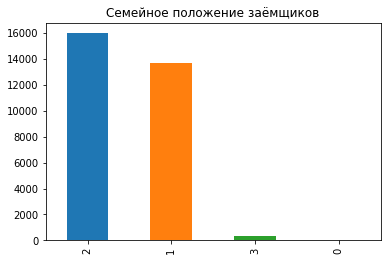

In [38]:
df['MARRIAGE'].value_counts().plot(kind='bar');
plt.title('Семейное положение заёмщиков');

Мы видим, что подавляющее большинство заёмщиков имеет два вида семейного положения:

1. Холост (самый распространенный вид)
2. Женат/Замужем

Построим графики распределения семейного положения заёмщиков в двух группах:

1. среди тех, кто вернул кредит
2. среди тех, кто не вернул

In [39]:
marriage_returned = df[df['default']==0]['MARRIAGE']
marriage_not_returned = df[df['default']==1]['MARRIAGE']

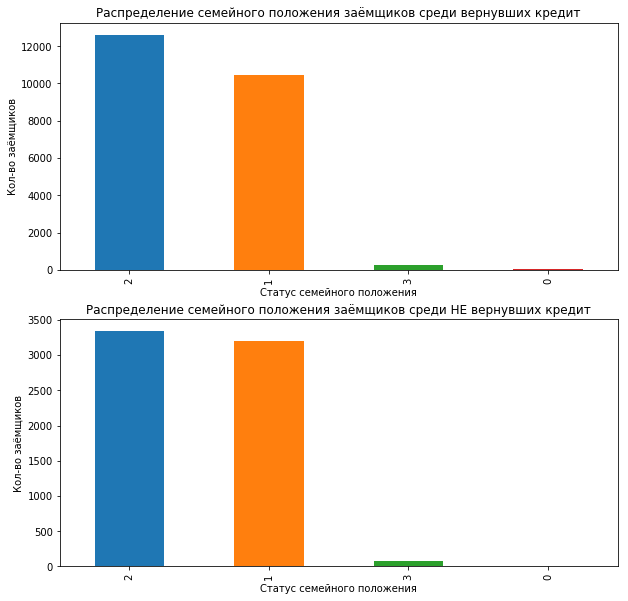

In [40]:
plt.figure(figsize=(10,10))

plt.subplot(211)
marriage_returned.value_counts().plot(kind='bar');
plt.xlabel('Статус семейного положения')
plt.ylabel('Кол-во заёмщиков')
plt.title('Распределение семейного положения заёмщиков среди вернувших кредит');

plt.subplot(212)
marriage_not_returned.value_counts().plot(kind='bar');
plt.xlabel('Статус семейного положения')
plt.ylabel('Кол-во заёмщиков')
plt.title('Распределение семейного положения заёмщиков среди НЕ вернувших кредит');

Из графиков мы видим, что распределение семейного положения заёмщиков в подгруппах схожи, но доля замужних и женатых среди не вернувших кредит выше. Исследуем это подробнее.

Доли семёного положения заёмщиков в численном выражении в обеих подгруппах: вернувших и не вернувших кредит:

In [41]:
marriage_returned.value_counts() / len(marriage_returned)

2    0.540276
1    0.447398
3    0.010229
0    0.002097
Name: MARRIAGE, dtype: float64

In [42]:
marriage_not_returned.value_counts() / len(marriage_not_returned)

2    0.503466
1    0.483122
3    0.012658
0    0.000753
Name: MARRIAGE, dtype: float64

Видно, что доля холостых заёмщиков не вернувших кредит (0.503466) меньше, чем доля вернувших (0.540276). А соотношение замужних и женатых обратное, доля замужних и женатых не вернувших кредит (0.483122) больше, чем вернувших (0.447398). И так далее. 

То есть по данным можно сказать, что статус семейного положения влияет на то, вернет ли человек долг или нет. Исследуем это подробнее.

В качестве меры измерения связи признаков семейного положения и возврат долга воспользуемся коэффициентом Крамера для измерения силы взаимосвязи между двумя категориальными признаками. 

Для подсчета коэффициента Крамера мы воспользуемся критерием/статистикой Хи-квадрат. Выше (в пункте 3) критерий Хи-квадрат был уже подробно описан, поэтому не будем здесь еще раз повторять. Из таблиц сопряженности expected_freqs и observed_freqs ниже видно, что условия применения критерия выполняются.

In [43]:
# Создадим таблицу сопряженности наблюдаемых значений: [marriage x default]
observed_freqs = []
unique_statuses = np.unique(df['MARRIAGE'])
for status in unique_statuses:
    observed_freqs.append([len(marriage_returned[marriage_returned==status]), 
                     len(marriage_not_returned[marriage_not_returned==status])])

observed_freqs = np.array(observed_freqs)
stat, pvalue, dof, expected_freqs = ss.chi2_contingency(observed_freqs, correction=True)

pvalue

8.825862457577375e-08

In [44]:
pd.DataFrame(observed_freqs)

,0,1
0,49,5
1,10453,3206
2,12623,3341
3,239,84


In [45]:
pd.DataFrame(expected_freqs)

,0,1
0,42.0552,11.9448
1,10637.6292,3021.3708
2,12432.7632,3531.2368
3,251.5524,71.4476


In [107]:
# Посчитаем коэффициент Крамера для наших признаков
np.sqrt(stat/(observed_freqs.sum()*(min(observed_freqs.shape) - 1)))

0.034478203662766466

Мы видим, что коэффициент Крамера близок к нулю, то есть взаимосвязь наших признаков мала, но она все-таки есть, пусть и не большая, также гипотеза о независимости признаков критерием Хи-квадрат отвергается на уровне значимости 0.05 в пользу альтернативы: зависимости признаков.

## 5. Исследование возраста заёмщиков

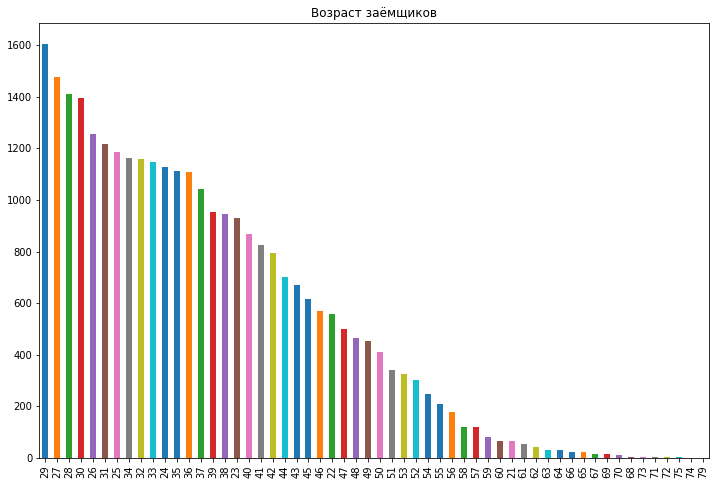

In [46]:
plt.figure(figsize=(12, 8))

df['AGE'].value_counts().plot(kind='bar');
plt.title('Возраст заёмщиков');

Мы видим, что количество заёмщиков достаточно равномерно убывает с возрастом. Возраст колеблется от 29 до 79 лет.

Построим графики распределения семейного положения заёмщиков в двух группах:

1. среди тех, кто вернул кредит
2. среди тех, кто не вернул

In [47]:
age_returned = df[df['default']==0]['AGE']
age_not_returned = df[df['default']==1]['AGE']

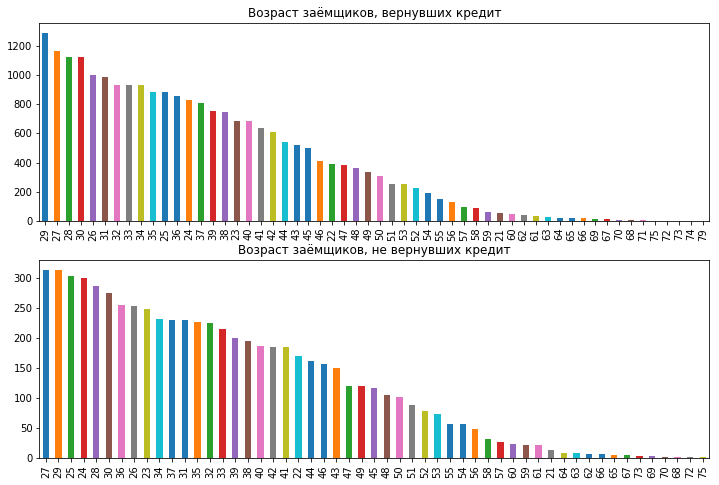

In [48]:
plt.figure(figsize=(12, 8))

plt.subplot(211)
age_returned.value_counts().plot(kind='bar');
plt.title('Возраст заёмщиков, вернувших кредит');

plt.subplot(212)
age_not_returned.value_counts().plot(kind='bar');
plt.title('Возраст заёмщиков, не вернувших кредит');

Из графиков мы видим, что распределения очень спохожи. Построим еще гистограммы распределений.

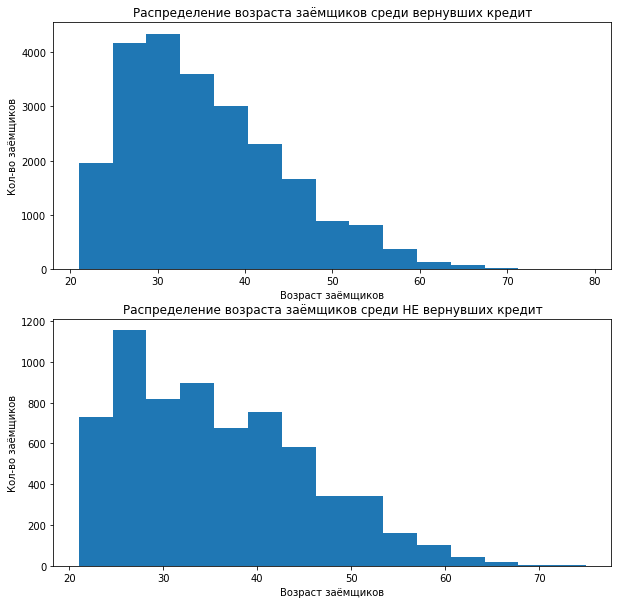

In [49]:
plt.figure(figsize=(10,10))

plt.subplot(211)
plt.hist(age_returned, bins=15);
plt.xlabel('Возраст заёмщиков')
plt.ylabel('Кол-во заёмщиков')
plt.title('Распределение возраста заёмщиков среди вернувших кредит');

plt.subplot(212)
plt.hist(age_not_returned, bins=15);
plt.xlabel('Возраст заёмщиков')
plt.ylabel('Кол-во заёмщиков')
plt.title('Распределение возраста заёмщиков среди НЕ вернувших кредит');

Мы видим, что распределения сильно скошены и далеки от нормального распределения.

Так же на графиках видно, что интервалы значений возраста для не вернувших кредит и для вернувших практически одинаковы: от 29 до 79.

#### 1. Проверим гипотезу о равенстве медианных значений возрастов людей

Так как мы не можем сделать предположения, из какого распределения получена наша выборка, то воспользуемся Bootstrap методом для получения интервальной оценки медиан каждой подвыборки: вернувших и не вернувших кредит.

In [110]:
# Получим интервальную оценку медианы для возраста заёмщиков, вернувших кредит. 
np.random.seed(0)

bootstrap_samples = create_bootstrap_samples(age_returned.values)
bootstrap_medians_0 = np.median(bootstrap_samples, axis=1)

med_stat_int_for_returned = get_stat_interval(bootstrap_medians_0, alpha=0.05)
print("95% доверительный интервал для медианы возраста заёмщиков, вернувших кредит: ({}, {})"
       .format(*med_stat_int_for_returned))

95% доверительный интервал для медианы возраста заёмщиков, вернувших кредит: (34.0, 34.0)


In [111]:
# Получим интервальную оценку медианы для возраста заёмщиков, НЕ вернувших кредит. 
np.random.seed(0)

bootstrap_samples = create_bootstrap_samples(age_not_returned.values)
bootstrap_medians_1 = np.median(bootstrap_samples, axis=1)

med_stat_int_for_not_returned = get_stat_interval(bootstrap_medians_1, alpha=0.05)
print("95% доверительный интервал для медианы возраста заёмщиков, не вернувших кредит: ({}, {})"
       .format(*med_stat_int_for_not_returned))

95% доверительный интервал для медианы возраста заёмщиков, не вернувших кредит: (34.0, 35.0)


Мы видим, что 95% доверительный интервалы, построенные с помощью Bootstrap,  пересекаются. Это говорит о том, что медианы распределений схожи, и гипотеза о равенстве медиан не отвергается на уровне значимости 0.05.

Построим доверительный интервал для разности медиан:

In [112]:
med_diff_int = get_stat_interval(bootstrap_medians_0 - bootstrap_medians_1, alpha=0.05)
print("95% доверительный интервал для разности медиан возраста заёмщиков, вернувших и не вернувших кредит: ({}, {})"
       .format(*med_diff_int))

95% доверительный интервал для разности медиан возраста заёмщиков, вернувших и не вернувших кредит: (-1.0, 0.0)


Мы видим, что доверительный интервал для разности содержит 0, то есть нельзя отвергнуть гипотезу о равенстве медиан на уровне значимости 0.05

#### 2. Проверим гипотезу о равенстве распределений

Так как наши подвыборки для возраста заёмщиков получены на разных объектах (заёмщиках - вернувших и не вернувших кредит), то воспользуемся критерием Манна-Уитни о равенстве распределений для независимых выборок.

Непараметрический ранговый критерий Манна-Уитни для независимых выборок:

1. Нулевая гипотеза: Распределения совпадают $F_{1}(x)$ = $F_{2}(x)$
2. Двусторонняя альтернатива: Распределения не совпадают $F_{1}(x)$ = $F_{2}(x+\Delta), $ где $ \Delta != 0$
3. Условия применимости: независимость выборок

In [113]:
ss.mannwhitneyu(age_returned, age_not_returned, alternative='two-sided')

MannwhitneyuResult(statistic=76966879.5, pvalue=0.3725035434898616)

Мы видим, что достигаемый уровень значимости критерия Манна-Уитни существенно больше 0.05, то есть гипотеза о равенстве распределений не отвеграется.

In [117]:
print('Численная оценка практической значимости = {}'
      .format(calc_fold_change(np.median(age_returned), np.median(age_not_returned))))

Численная оценка практической значимости = 1.0


Из численной оценки практической значимости мы видим, что средний возраст вернувших кредит такой же как и у тех, кто не вернул кредит. То есть существенный отличий в этом признаке нет.

С логической точки зрения результаты интересны и значимы, так как из здравого смысла мы НЕ можем сделать предположение, что возраст НЕ влияет на распределение заёмщиков среди вернувших и не вернувших кредит (кажется, что доля невозврата кредита должна быть выше среди молодых людей, которые ещё не встали на ноги и могут быть более "безрассудны" в своих решениях, чем люди в возрасте). Поэтому НЕ отвержение гипотез о равенстве медиан и распределений данных даёт некоторые основания полагать, что возраст НЕ влияет на возврат долга.